In [28]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from file import save_file
from statistics import mean
from datetime import date
import file

In [29]:
# Define the ticker symbol
symbol = 'TQQQ'

# Get data on this ticker
tickerData = yf.Ticker(symbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())
# display(history)

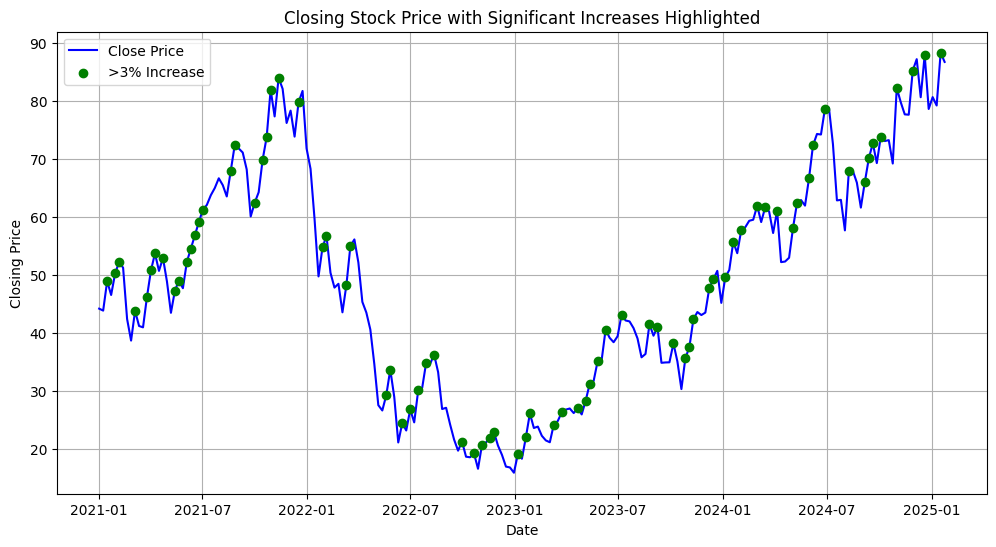

In [30]:
# Calculate the percentage change of the closing price
history['Pct_Change'] = history['Close'].pct_change()

# Identify points where the closing price is more than 3% above the previous close
history['Above_3_Percent'] = history['Pct_Change'] > 0.03

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(history['Close'], label='Close Price', color='blue')

# Highlight points where the closing price is more than 3% above the previous close
above_3_percent = history[history['Above_3_Percent']]
plt.scatter(above_3_percent.index, above_3_percent['Close'], color='green', label='>3% Increase', zorder=5)

# Add labels, title, and legend
plt.title('Closing Stock Price with Significant Increases Highlighted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()

# Show the plot
plt.show()

<Axes: title={'center': 'TQQQ 1w option performance'}, xlabel='Date'>

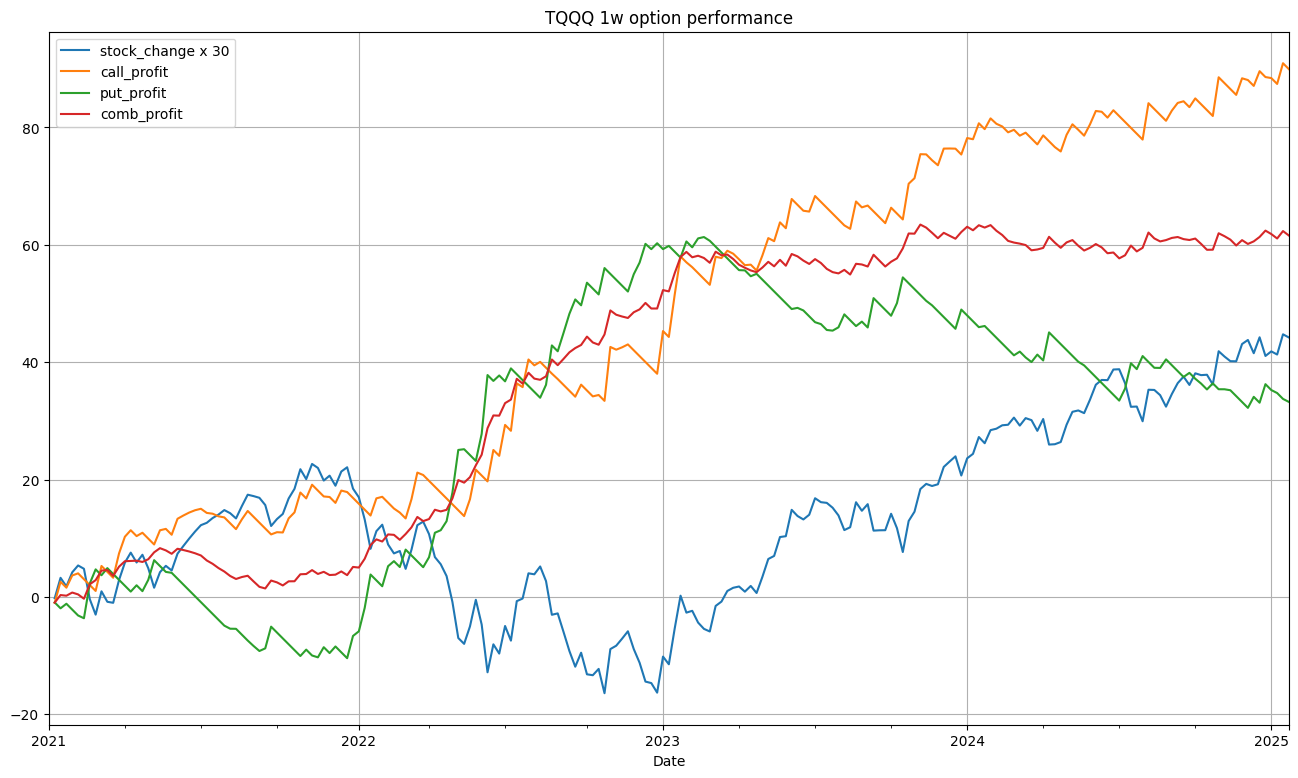

In [31]:
opt_rel_price = 0.024
gap = 0.5 / 80

history['stock_change'] = history.Close.pct_change(periods=1)
history['call_profit'] = ((history.stock_change - gap) / opt_rel_price - 1).clip(lower=-1)
history['put_profit'] = ((-history.stock_change - gap) / opt_rel_price - 1).clip(lower=-1)
history['comb_profit'] = (history.call_profit + history.put_profit) / 2

history['stock_change x 30'] = history['stock_change'] * 30
history[['stock_change x 30', 'call_profit', 'put_profit', 'comb_profit']].cumsum() \
  .plot(figsize=(16,9), grid=True, title=symbol+' 1w option performance')

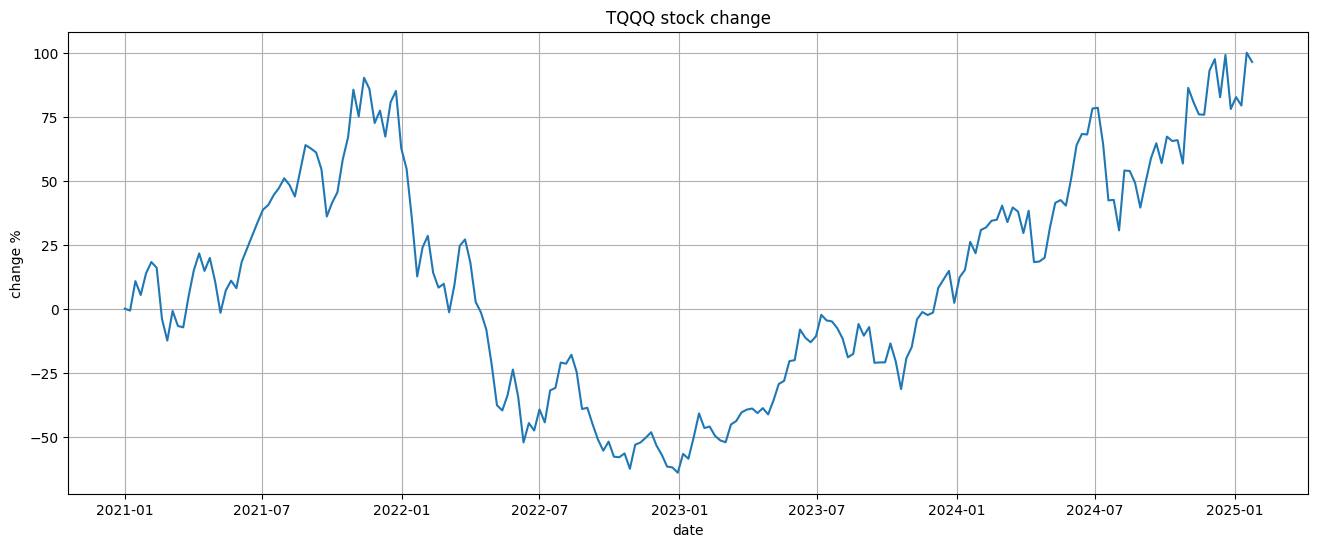

In [32]:
plt.figure(figsize=(16,6))
plt.plot((history.Close / history.Close.iloc[0]) * 100 - 100)
plt.title(symbol + ' stock change')
plt.xlabel('date')
plt.ylabel('change %')
plt.grid()
plt.show()

In [33]:
max_weeks = 50
gap = (0.5 / 80) * 100 # %
option_prices = {
    1: [56/1.42, 57/1.23, 59/1.54, 83/1.96, 84/1.82, 87/2.38],
    2: [56/2, 57/2.03, 59/2.34, 83/3.05, 84/3.10, 87/3.4],
    3: [56/2.53, 57/2.68, 59/2.71, 83/3.75, 84/3.97, 87/4.1],
    4: [52/3.22, 56/3.1, 57/2.98, 59/3.15, 83/4.65, 84/4.59, 87/4.55],
    5: [56/3.42, 57/3.08, 59/3.31, 83/4.45, 84/4.70, 87/5.27],
    6: [56/3.47, 57/3.7, 59/3.9, 83/5.9, 84/5.65, 87/5.87],
    7: [57/4.15, 59/3.43, 83/6.0],
    8: [56/4.4, 87/6.9],
    9: [52/4.87, 84/6.85],
    11: [83/8.25],
    19: [59/7.37],
    20: [57/7.37],
    21: [56/7.3, 87/12.07],
    22: [52/7.65, 84/11.50],
    24: [83/12.52],
    32: [59/10.23],
    33: [57/10.02],
    34: [56/9.95, 87/15.77],
    35: [52/9.98, 84/14.00],
    36: [59/10.8],
    37: [57/10.57],
    38: [56/10.75],
    39: [52/10.42],
    51: [87/19.60],
    52: [84/19.30],
    103:[87/28.80],
    104:[85/27.40]
}

print('raw option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}

# normalize values so longer expirations have lower leverage
option_leverage = {k: v for k, v in zip(sorted(option_leverage.keys()), sorted(option_leverage.values(), reverse=True))}

print('sorted mean option leverage, break even:')
for w, v in sorted(option_leverage.items()):
    print(f'\t{w:2}w {v:4.1f} {gap + 100/v:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(symbol, option_leverage)

raw option leverages:
	 1w 39.4 46.3 38.3 42.3 46.2 36.6
	 2w 28.0 28.1 25.2 27.2 27.1 25.6
	 3w 22.1 21.3 21.8 22.1 21.2 21.2
	 4w 16.1 18.1 19.1 18.7 17.8 18.3 19.1
	 5w 16.4 18.5 17.8 18.7 17.9 16.5
	 6w 16.1 15.4 15.1 14.1 14.9 14.8
	 7w 13.7 17.2 13.8
	 8w 12.7 12.6
	 9w 10.7 12.3
	11w 10.1
	19w  8.0
	20w  7.7
	21w  7.7  7.2
	22w  6.8  7.3
	24w  6.6
	32w  5.8
	33w  5.7
	34w  5.6  5.5
	35w  5.2  6.0
	36w  5.5
	37w  5.4
	38w  5.2
	39w  5.0
	51w  4.4
	52w  4.4
	103w  3.0
	104w  3.1
sorted mean option leverage, break even:
	 1w 41.5  3.0%
	 2w 26.9  4.3%
	 3w 21.6  5.3%
	 4w 18.2  6.1%
	 5w 17.6  6.3%
	 6w 15.1  7.3%
	 7w 14.9  7.3%
	 8w 12.7  8.5%
	 9w 11.5  9.3%
	11w 10.1 10.6%
	19w  8.0 13.1%
	20w  7.7 13.6%
	21w  7.4 14.1%
	22w  7.1 14.8%
	24w  6.6 15.7%
	32w  5.8 18.0%
	33w  5.7 18.2%
	34w  5.6 18.5%
	35w  5.6 18.6%
	36w  5.5 18.9%
	37w  5.4 19.2%
	38w  5.2 19.8%
	39w  5.0 20.7%
	51w  4.4 23.2%
	52w  4.4 23.6%
	103w  3.1 32.9%
	104w  3.0 33.7%
option gap: 0.62%


In [45]:
stock_change = [None] # no change for 0 weeks
option_performance = []
history['Change'] = history['Close'].pct_change(periods=1) * 100
for weeks in range(1, max_weeks):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median() * 52 / weeks) # annualized

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() / weeks 
        median_profit = option_profits.median() / weeks
        positive_percent = (option_profits > 0).mean() * 100
        option_performance.append([weeks, mean_profit, positive_percent, median_profit])
        history[f'Option {weeks}w'] = option_profits

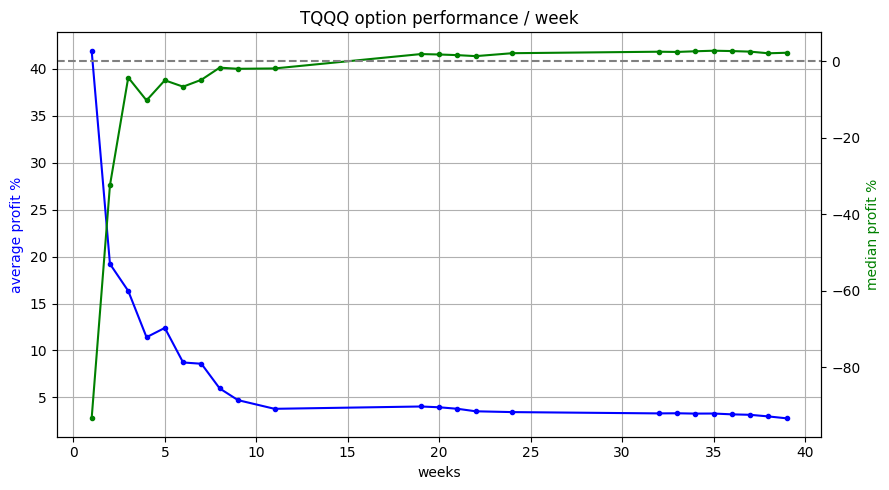

In [65]:
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
median_profit = [p[3] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]

fig, ax1 = plt.subplots(figsize=(9, 5))

ax2 = ax1.twinx()

ax1.plot(option_weeks, option_profit, label='Average option profit', marker='.', color='b')
ax2.plot(option_weeks, median_profit, label='Median option profit', marker='.', color='g')

ax1.set_title(symbol + ' option performance / week')
ax1.set_xlabel('weeks')
ax1.set_ylabel('average profit %', color='b')
ax2.set_ylabel('median profit %', color='g')
ax2.axhline(y=0, color='grey', linestyle='--')

ax1.grid()

plt.tight_layout()
plt.show()

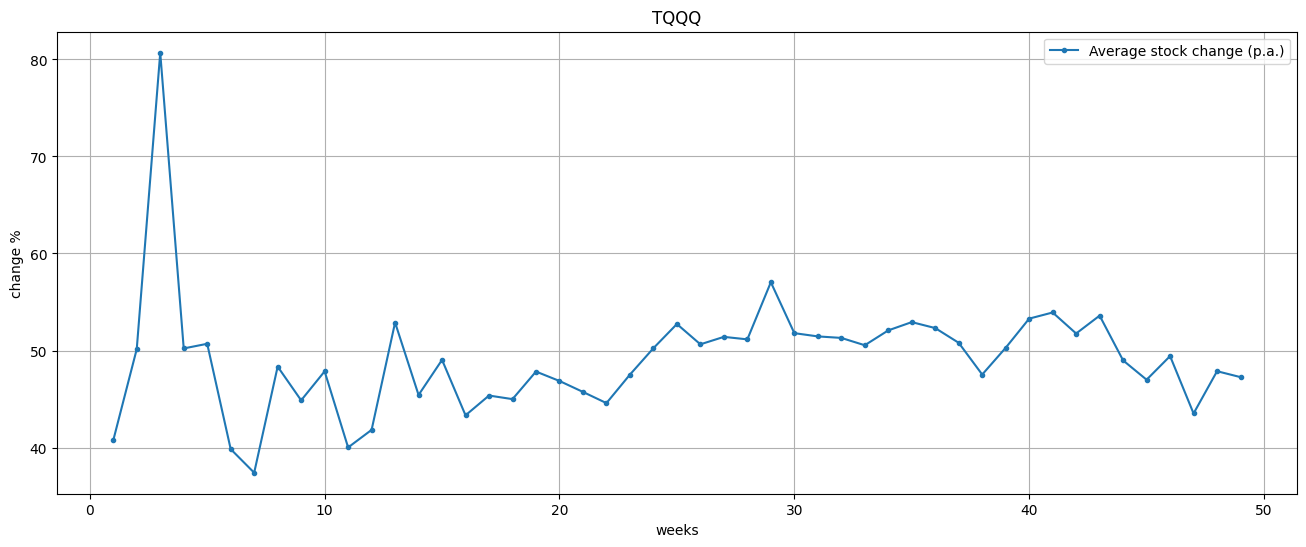

In [36]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Average stock change (p.a.)', marker='.')
plt.legend(loc='upper right')
plt.title(symbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


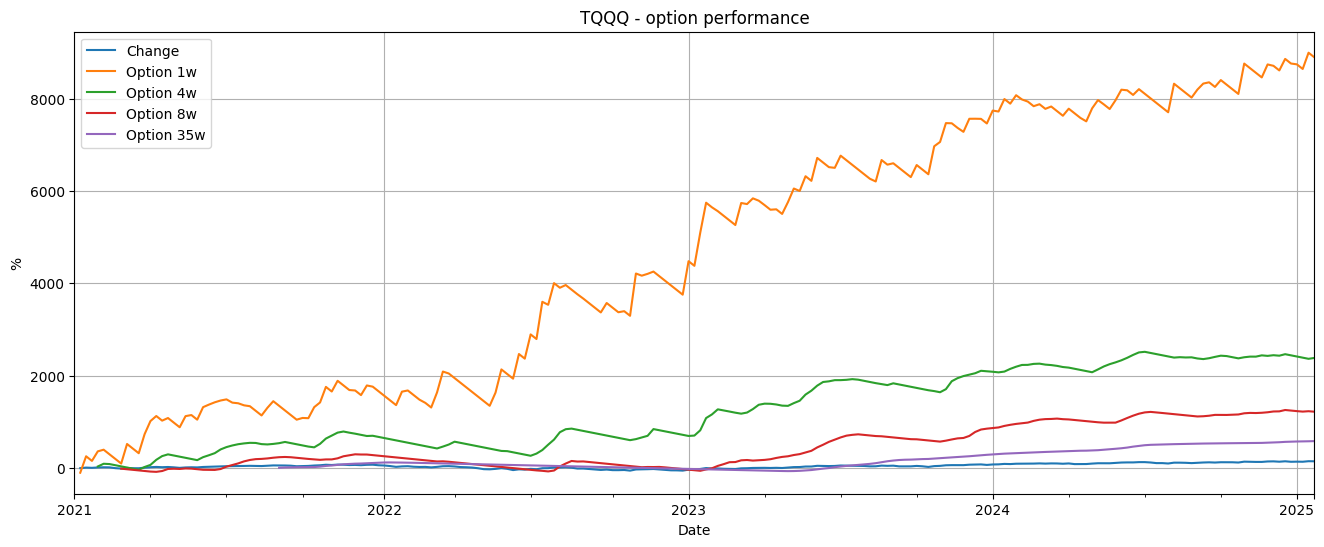

In [37]:
plt.figure(figsize=(16,6))
history['Change'].cumsum().plot()

for w in [1,4,8,35]:
    (history[f'Option {w}w'].cumsum()/w).plot()

plt.legend(loc='upper left')
plt.title(f'{symbol} - option performance')
plt.ylabel('%')
# plt.yscale('log')
plt.grid()
plt.show()


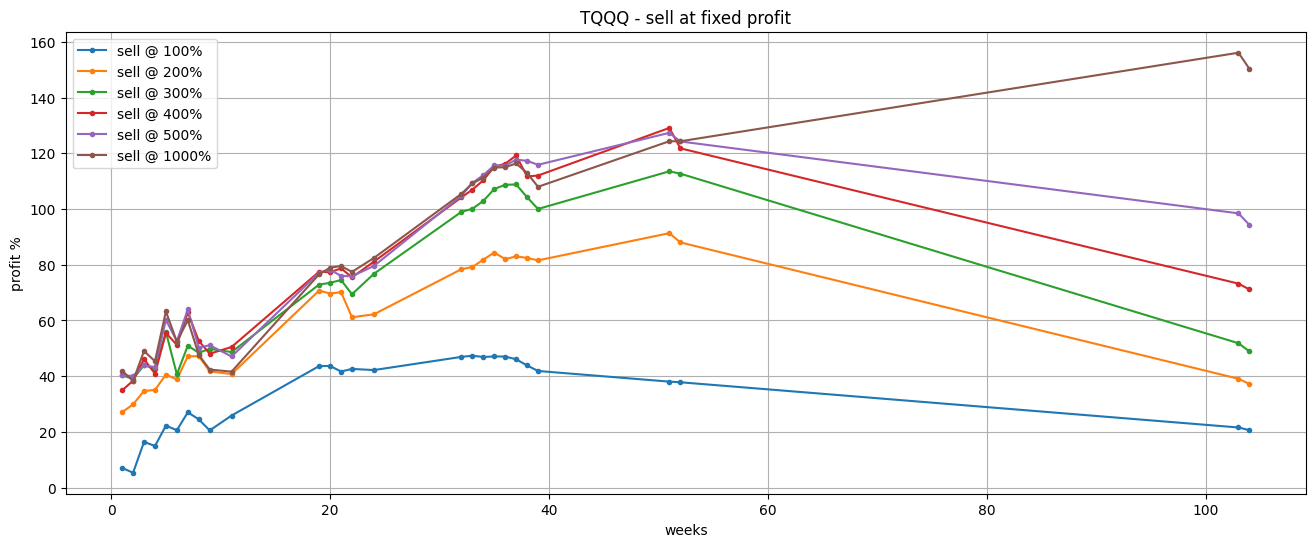

In [38]:
plt.figure(figsize=(16,6))

for maxprofit in [100,200,300,400,500,1000]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        WStart = history.Close.shift(weeks)
        WHigh = history.High.rolling(window=weeks).max()
        eow_profit = (((history.Close / WStart - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax_profit = (((WHigh / WStart - 1) * 100 - gap) * lvr - 100).clip(upper=maxprofit)
        profit = wmax_profit.where(wmax_profit >= maxprofit, eow_profit)
        data[weeks] = profit[weeks:].mean()

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {maxprofit}%', marker='.')

plt.legend()
plt.title(f'{symbol} - sell at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()